In [1]:
% run utils.ipynb

In [2]:
df = pd.read_csv('../data/etymwn.tsv', sep='\t', header=None)
df.columns = ['src', 'rel', 'to']
df.head()

,src,rel,to
0,aaq: Pawanobskewi,rel:etymological_origin_of,eng: Penobscot
1,aaq: senabe,rel:etymological_origin_of,eng: sannup
2,abe: waniigan,rel:etymological_origin_of,eng: wangan
3,abe: waniigan,rel:etymological_origin_of,eng: wannigan
4,abs: beta,rel:etymological_origin_of,zsm: beta


In [3]:
df['src_lang'] = df.src.apply(lambda x: x.split(':')[0].strip())
df['src_word'] = df.src.apply(lambda x: x.split(':')[1].strip())
df['to_lang'] = df.to.apply(lambda x: x.split(':')[0].strip())
df['to_word'] = df.to.apply(lambda x: x.split(':')[1].strip())
df.head()

,src,rel,to,src_lang,src_word,to_lang,to_word
0,aaq: Pawanobskewi,rel:etymological_origin_of,eng: Penobscot,aaq,Pawanobskewi,eng,Penobscot
1,aaq: senabe,rel:etymological_origin_of,eng: sannup,aaq,senabe,eng,sannup
2,abe: waniigan,rel:etymological_origin_of,eng: wangan,abe,waniigan,eng,wangan
3,abe: waniigan,rel:etymological_origin_of,eng: wannigan,abe,waniigan,eng,wannigan
4,abs: beta,rel:etymological_origin_of,zsm: beta,abs,beta,zsm,beta


In [10]:
df.rel.unique()

array(['rel:etymological_origin_of', 'rel:has_derived_form',
       'rel:is_derived_from', 'rel:etymology',
       'rel:etymologically_related', 'rel:variant:orthography',
       'rel:derived', 'rel:etymologically'], dtype=object)

In [11]:
df.src_lang.unique().shape

(397,)

In [12]:
df.src_word.unique().shape

(2743415,)

In [13]:
df.to_lang.unique().shape

(397,)

In [14]:
df.to_word.unique().shape

(2738470,)

In [15]:
df.shape

(6031431, 7)

# PART 1 : Word graph exploration

### Remove ambiguous relationships - about half of dataset

In [16]:
relations = df[df.rel  != 'rel:etymology']
relations = relations[relations.rel  != 'rel:is_derived_from']
relations = relations[relations.rel  != 'rel:etymologically_related']

In [17]:
relations = relations[['src_lang', 'src_word', 'to_lang','to_word']]

In [18]:
relations.shape

(2754696, 4)

In [19]:
relations.drop_duplicates().shape

(2708574, 4)

### !!! Mutltiple relations possible between a given src wordLang and dest wordLang !!!

In [86]:
def recurse(dataFrame, langWord, currentRelations, depth):
    relatedWords = dataFrame[dataFrame.to_word == langWord[1]]
    relatedWords = relatedWords[relatedWords.to_lang == langWord[0]]
    relatedWords = relatedWords[['src_lang', 'src_word']]
    relatedWords = [tuple(x) for x in relatedWords.values]
    
    depths = [depth]
    for langWord in relatedWords:
        if langWord not in currentRelations:
            depths.append(depth + 1)
            currentRelations.append(langWord)
            currentRelations, tmpDepth = recurse(dataFrame, langWord, currentRelations, depth 
            depths.append(tmpDepth)
    
    return currentRelations, max(depths)

SyntaxError: invalid syntax (<ipython-input-86-5cdc66fa8645>, line 14)

In [36]:
testLangWord = ('deu', 'Fledermaus')
recurse(relations, testLangWord, [testLangWord], 0)

([('deu', 'Fledermaus'),
  ('deu', 'Maus'),
  ('goh', 'mus'),
  ('gml', 'vledermus'),
  ('gml', 'mus'),
  ('p_gem', 'mus'),
  ('p_ine', 'muh₂s'),
  ('goh', 'fledarmus')],
 4)

In [28]:
langWords = relations[['to_lang','to_word']].drop_duplicates()
langWords = [tuple(x) for x in langWords.values]
len(langWords)

2451666

In [30]:
stepSize  = 10000
print('Numer of samples: ' + str(int(len(langWords) / stepSize)))

Numer of samples: 245


In [31]:
bar = progressbar.ProgressBar(widgets=[
    ' [', progressbar.Timer(), '] ',
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
])

In [32]:
depths = []
numberOfRels = []
counter = 0
for i  in bar(range(int(len(langWords) / stepSize))):
    langWord = langWords[counter]
    rels, depth = recurse(relations, langWord, [langWord], 0)
    numberOfRels.append(len(rels) - 1)
    depths.append(depth)
    counter = counter + stepSize

 [Elapsed Time: 0:02:10] |###################################| (Time: 0:02:10) 


## This would take about 10 secs in c++, fck off python

(array([   0.,  155.,   40.,   26.,   10.,   12.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

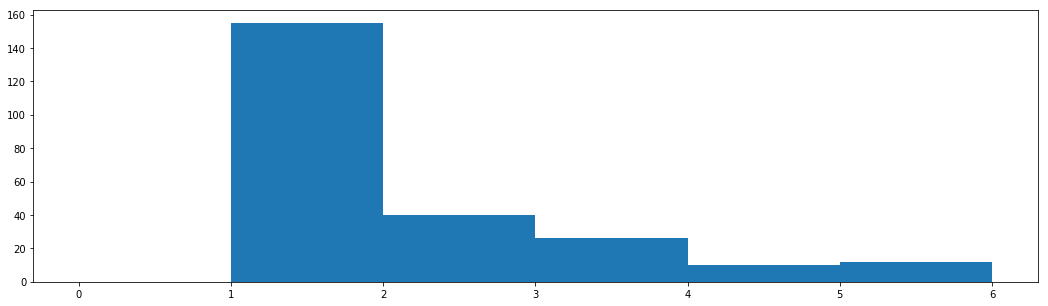

In [33]:
plt.hist(depths, range(max(depths)))

### Number of words which have depth x

(array([   0.,  155.,   40.,   26.,   10.,    9.,    3.,    2.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 14 Patch objects>)

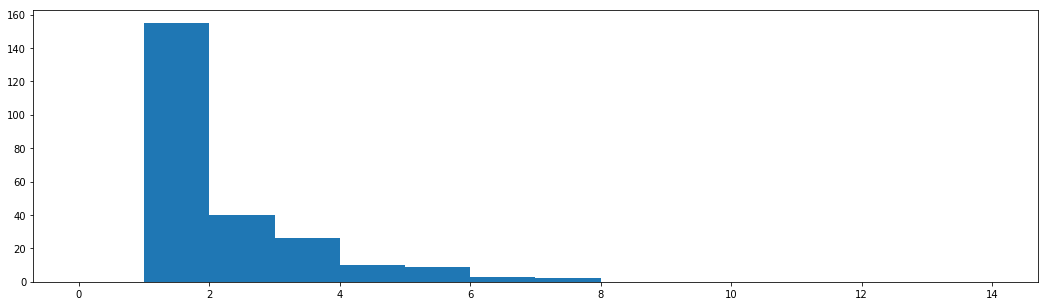

In [34]:
plt.hist(depths, range(max(numberOfRels)))

### Number or words which have x related words

# Language exploration

In [26]:
langs = df.src_lang.unique()
langs = np.append(langs, df.to_lang.unique())
langs = list(set(langs))
len(langs)

397

In [27]:
bar = progressbar.ProgressBar(widgets=[
    ' [', progressbar.Timer(), '] ',
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
])

In [28]:
wordCountForLang = dict()
for i in bar(range(len(langs))):
    lang = langs[i]
    toWordsForLang = (df[df.to_lang == lang]).to_word.unique()
    wordsForLang = np.append(toWordsForLang, (df[df.src_lang == lang]).src_word.unique())
    wordCountForLang[lang] = len(wordsForLang)
    

 [Elapsed Time: 0:04:38] |###################################| (Time: 0:04:38) 


In [29]:
langAndWordCounts = list(wordCountForLang.items())
langAndWordCounts = sorted(langAndWordCounts, key=lambda x: x[1], reverse=True)

In [30]:
print("Min words for any language: " + str(langAndWordCounts[-1]))
print("Median words for any language: " + str(langAndWordCounts[int(len(langAndWordCounts) / 2)]))
print("Max words for any language: " + str(langAndWordCounts[0]))

Min words for any language: ('p_gmw', 2)
Median words for any language: ('bar', 34)
Max words for any language: ('lat', 1282431)


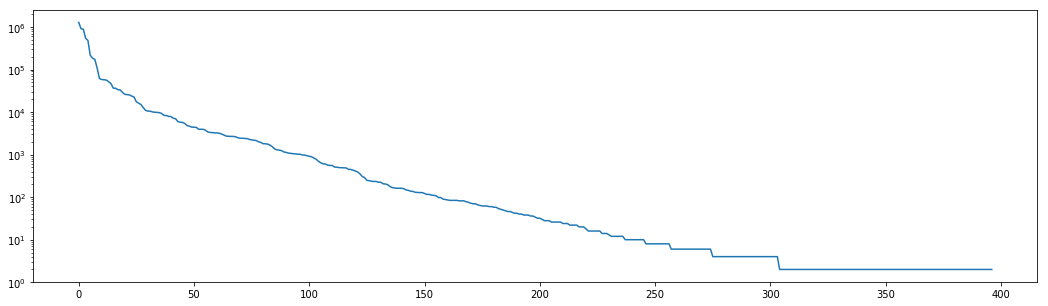

In [31]:
plt.plot([x[1] for x in langAndWordCounts])
plt.yscale('log')

### About 100 languages have more than 1000 words 

# Exploration of french

In [65]:
frenchWords = list(relations[relations.to_lang == 'fra'].to_word.unique())
len(frenchWords)

250818

In [66]:
stepSize  = 1084
print('Numer of samples: ' + str(int(len(frenchWords) / stepSize)))

Numer of samples: 231


In [67]:
bar = progressbar.ProgressBar(widgets=[
    ' [', progressbar.Timer(), '] ',
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
])

In [68]:
langs = ['fra']
depths = [0]
counter = 0
for i  in bar(range(int(len(frenchWords) / stepSize))):
    langWord = ('fra', frenchWords[counter])
    relatedWords, depth = recurse(relations, langWord, [langWord], 0)
    depths.append(depth)
    langs.extend([x[0] for x in relatedWords])
    counter = counter + stepSize

 [Elapsed Time: 0:02:26] |###################################| (Time: 0:02:26) 


In [69]:
print("Number of unique languages related to a french word: " + str(len(set(langs))))

Number of unique languages related to a french word: 18


(array([   2.,    8.,    3.,  609.,   64.,   20.,    2.,  183.,    2.,    4.]),
 array([  0. ,   1.7,   3.4,   5.1,   6.8,   8.5,  10.2,  11.9,  13.6,
         15.3,  17. ]),
 <a list of 10 Patch objects>)

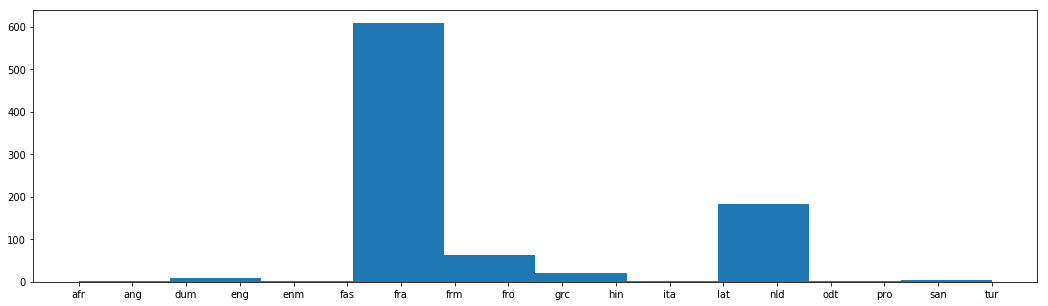

In [70]:
plt.hist(langs)

(array([   2.,  114.,   27.,    0.,   34.,   33.,    0.,   15.,    4.,    3.]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

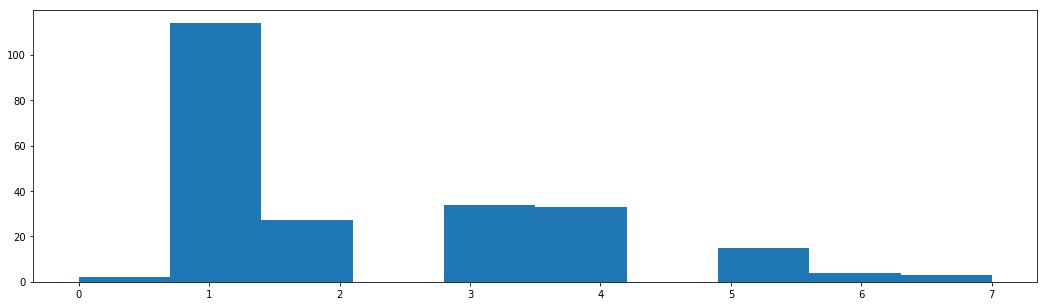

In [71]:
plt.hist(depths)

# Exploration of german

In [73]:
germanWords = list(relations[relations.to_lang == 'deu'].to_word.unique())
len(germanWords)

70901

In [80]:
stepSize  = 283
print('Numer of samples: ' + str(int(len(germanWords) / stepSize)))

Numer of samples: 250


In [81]:
bar = progressbar.ProgressBar(widgets=[
    ' [', progressbar.Timer(), '] ',
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
])

In [82]:
langs = ['deu']
depths = [0]
counter = 0
for i  in bar(range(int(len(germanWords) / stepSize))):
    langWord = ('deu', germanWords[counter])
    relatedWords, depth = recurse(relations, langWord, [langWord], 0)
    depths.append(depth)
    langs.extend([x[0] for x in relatedWords])
    counter = counter + stepSize

 [Elapsed Time: 0:02:24] |###################################| (Time: 0:02:24) 


In [84]:
print("Number of unique languages related to a german word: " + str(len(set(langs))))

Number of unique languages related to a german word: 16


(array([   2.,  666.,   10.,   16.,    5.,   24.,  112.,    4.,    5.,   22.]),
 array([  0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,  12. ,
         13.5,  15. ]),
 <a list of 10 Patch objects>)

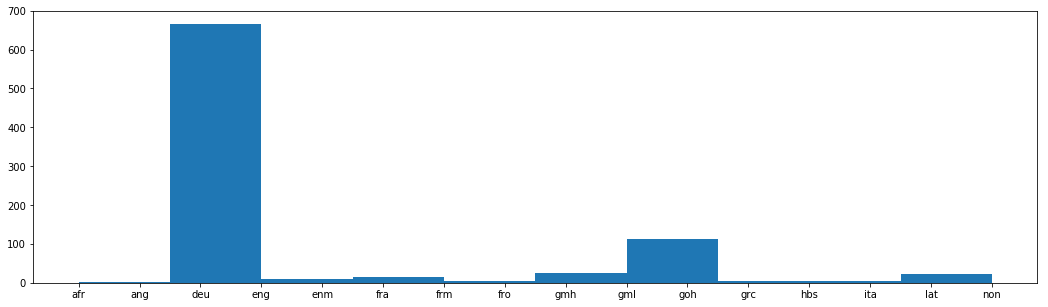

In [83]:
plt.hist(langs)

(array([   1.,  124.,    0.,   53.,    0.,   50.,   15.,    0.,    6.,    2.]),
 array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,  6. ]),
 <a list of 10 Patch objects>)

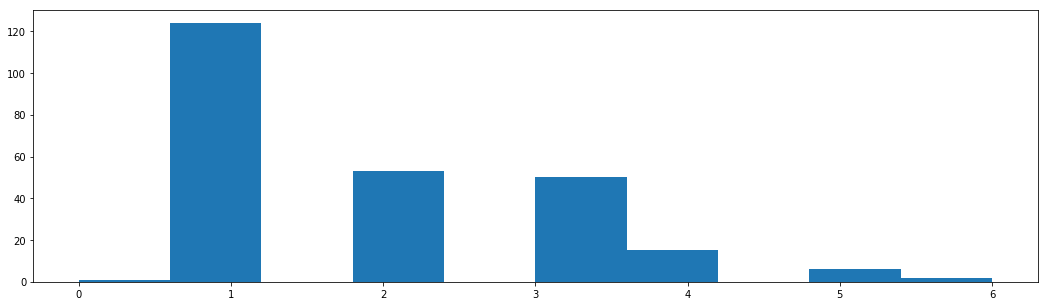

In [85]:
plt.hist(depths)